# Extracción de características

## Sonidos de Korotkoff

**Objetivo**: Determinar los valores de presión sistólica y diastólica mediante una implementación digital del método auscultatorio para la medición de presión sanguínea.

El método auscultatorio para la medición de la presión sanguínea es una técnica ampliamente utilizada y de gran relevancia en el campo de la medicina para evaluar la presión arterial en pacientes. Esta metodología se basa en la detección y análisis de los sonidos de Korotkoff, los cuales se generan durante la medición de la presión arterial mediante un esfigmomanómetro y un estetoscopio. Estos sonidos característicos reflejan el flujo sanguíneo a través de las arterias y proporcionan información valiosa sobre la salud cardiovascular del paciente.

En este método, un manguito de presión es colocado alrededor del brazo del paciente y se infla gradualmente para comprimir las arterias. A medida que el manguito se desinfla lentamente, el flujo sanguíneo en las arterias es restaurado de forma intermitente, generando una serie de sonidos pulsátiles conocidos como los sonidos de Korotkoff.

Estos sonidos pueden ser clasificados en cinco fases distintas, que varían según el flujo sanguíneo y la presión en las arterias durante el proceso de inflado y desinflado del manguito. Las cinco fases de los sonidos de Korotkoff son:

1. Fase I: Aparición del primer sonido claro y rítmico, conocido como "primer ruido de Korotkoff". Este sonido indica el retorno del flujo sanguíneo en la arteria a medida que la presión del manguito disminuye y coincide con la presión sistólica.

2. Fase II: Sonido murmullo suave que acompaña al primero, con tonalidades más suaves. Aunque su interpretación no es esencial para la medición de la presión arterial, su presencia puede proporcionar información adicional sobre el estado cardiovascular del paciente.

3. Fase III: Intensificación del murmullo de la fase II, siendo más nítido y de mayor intensidad. Suele corresponder con una disminución en la velocidad del flujo sanguíneo.

4. Fase IV: Desaparición progresiva del murmullo de la fase III, lo que indica una disminución significativa del flujo sanguíneo en la arteria.

5. Fase V: Ausencia total de sonidos, lo que indica que el flujo sanguíneo ha sido completamente restaurado y coincide con la presión diastólica.

<center><img src="../figures/MetodoKorotkoff.png"/></center>


## Actividades

1. Analizar el archivo 'sonidos_koff.npz'
2. Obtener la FFT de la señal de manera digital e identificar la interferencia
3. Diseñar un filtro Chebyshev tipo 1 adecuado
4. Caracterizar la respuesta en frecuencia del filtro
5. Analizar el efecto del filtro en la señal
6. Obtener los valores de presión sistólica y diastólica

## Información adicional
- El archivo 'sonidos_koff.npz' contiene
    - sonidos: La señal de audio con los sonidos de Korotkoff registrados
    - presion: La presión registrada en el baumanómetro durante el procedimiento
    - sr: La frecuencia de muestreo de ambas señales

## Solución

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.signal      as sg
from   scipy.signal      import hilbert, find_peaks


### 1. Analizar el archivo 'sonidos_koff.npz'

##### Cargar el archivo solicitado

In [2]:
datos = np.load("../signals/sonidos_koff.npz")
print(datos.keys())

KeysView(NpzFile '../signals/sonidos_koff.npz' with keys: sonidos, presion, sr)


##### Extraer la información del archivo

In [3]:
sonidos = datos["sonidos"]
presion = datos["presion"]
sr = datos["sr"]


##### Analizar el contenido de cada variable

In [4]:
print(f"Frecuencia de muestreo: {sr} Hz")

Frecuencia de muestreo: 1000.0 Hz


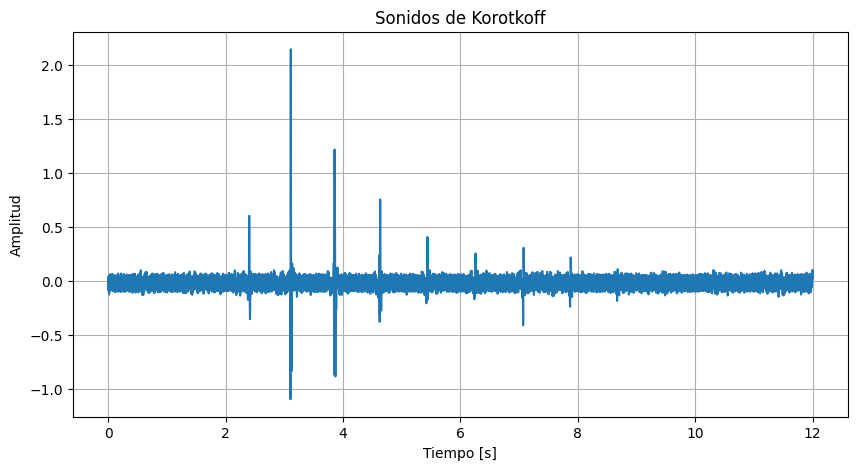

In [5]:
# Sonidos
t = np.linspace(0, len(sonidos)/sr, len(sonidos))
plt.figure(figsize=(10, 5))
plt.plot(t, sonidos)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Sonidos de Korotkoff')
plt.grid()
plt.show()

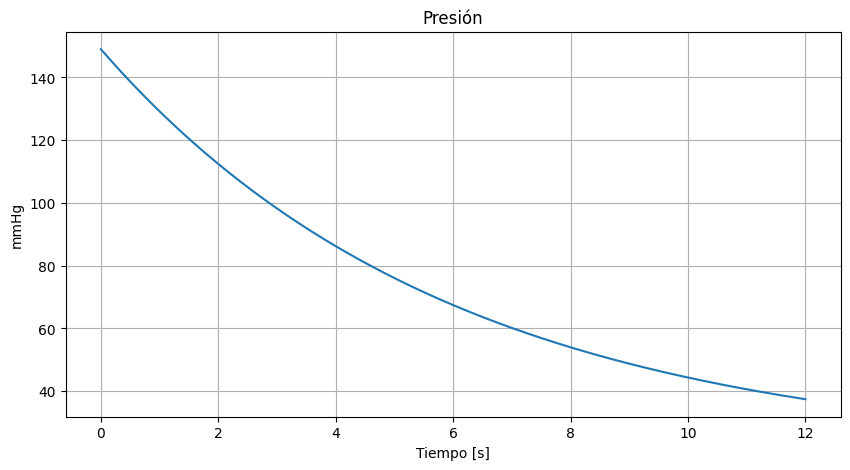

In [6]:
# Presión
plt.figure(figsize=(10, 5))
plt.plot(t, presion)
plt.xlabel('Tiempo [s]')
plt.ylabel('mmHg')
plt.title('Presión')
plt.grid()
plt.show()

In [7]:
def plot_sounds_pressure(sounds, pressure, time, title=None):
    fig, ax1 = plt.subplots()

    fig.set_size_inches(10, 5)
    if title:
        fig.suptitle(title, fontsize=20)

    color = 'tab:red'
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Presión [mmHg]', color=color)
    ax1.plot(time, pressure, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Sonidos de Korotkoff', color=color)
    ax2.plot(time, sounds, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.grid()
    plt.show()

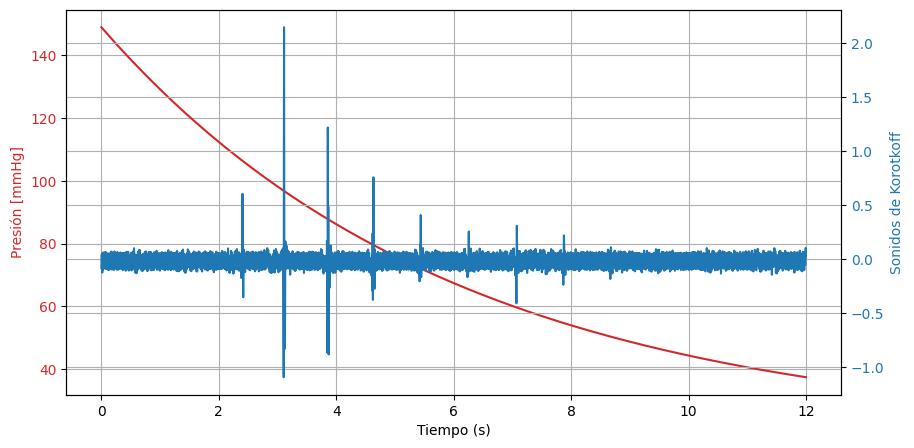

In [8]:
# Presión y sonidos
plot_sounds_pressure(sonidos, presion, t)


### 2. Obtener FFT de sonidos

In [9]:
def fou(senal,sr):
    """
    Función utilizada para calcular la transformada de Fourier de una señal.

    :param np.ndarray senal: Señal a analizar.
    :param int sr: Frecuencia de muestreo de la señal de audio.
    :return np.ndarray h: Espectro de amplitud de la señal.
    :return np.ndarray w: Frecuencias asociadas al espectro de amplitud.
    """
    f = np.fft.fft(senal)
    h = 20*np.log10(np.abs(f))[:int(f.shape[0]/2)]
    w = np.linspace(0,sr/2,int(f.shape[0]/2))
    
    return h, w


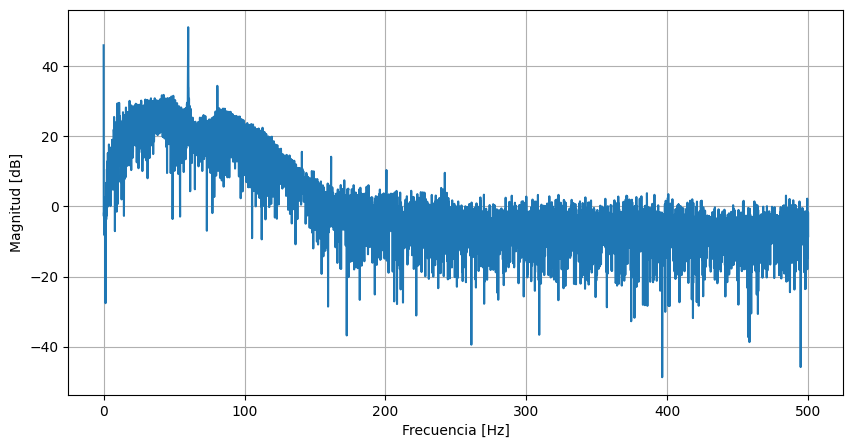

In [10]:
h, w = fou(sonidos, sr)
plt.figure(figsize=(10, 5))
plt.plot(w, h)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()
plt.show()

Los sonidos de Korotkoff presentan un rango de frecuencias dentro del rango 20-300 Hz, sin embargo, gracias al espectro de frecuencias obtenido se puede determinar que la señal se encuentra altamente contaminada, tanto por bajas como altas frecuencias.

Haciendo una amplificación al rango de 0-120 Hz podemos determinar que el contenido espectral rescatable de la señal se encuentra aproximadamente entre los 20 y 50 Hz, por lo que necesitaremo un filtro pasa banda para lograr limpiar la señal.

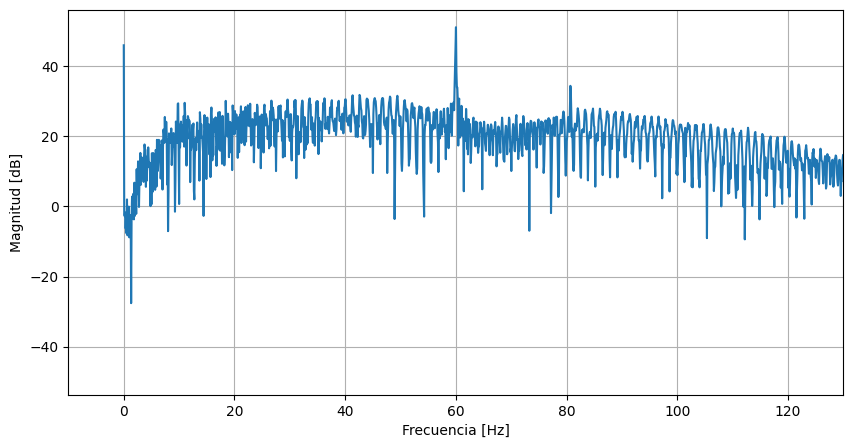

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(w, h)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(-10, 130)
plt.grid()
plt.show()

### 3,4 Diseño y caracterización del filtro

In [12]:
def freqz_plot(b, a, sr):
    """
    Función para obtener la caracterización de filtros digitales.

    :param np.ndarray b: Coeficientes 'b' del diseño del filtro.
    :param np.ndarray a: Coeficientes 'a' del diseño del filtro.
    :para float sr: Frecuencia de muestreo.
    :return np.ndarray w: Frecuencias asociadas a la respuesta en frecuencia.
    :return np.ndarray W: Fase de la respuesta en frecuencia.
    :return np.ndarray H: Magnitud de la respuesta en frecuencia.
    """
    w,h     = sg.freqz(b,a)
    h[h==0] = 1E-5
    H       = 20*np.log10(np.abs(h))
    W       = np.angle(h)
    W       = np.unwrap(W)
    W       = np.degrees(W)
    w       = np.linspace(0,sr/2,H.shape[0])

    return w, W, H

Se diseñará un filtro Chebyshev tipo 1, buscando centrar la banda de paso entre 20 y 50 Hz

In [13]:
wp = 2*np.array([23., 47.])/sr
ws = 2*np.array([17., 53.])/sr
gpass = 3
gstop = 40
N, Wn = sg.cheb1ord(wp, ws, gpass, gstop)

print('Orden del filtro: ', N)
print('Frecuencia de corte: ', Wn)


Orden del filtro:  7
Frecuencia de corte:  [0.046 0.094]


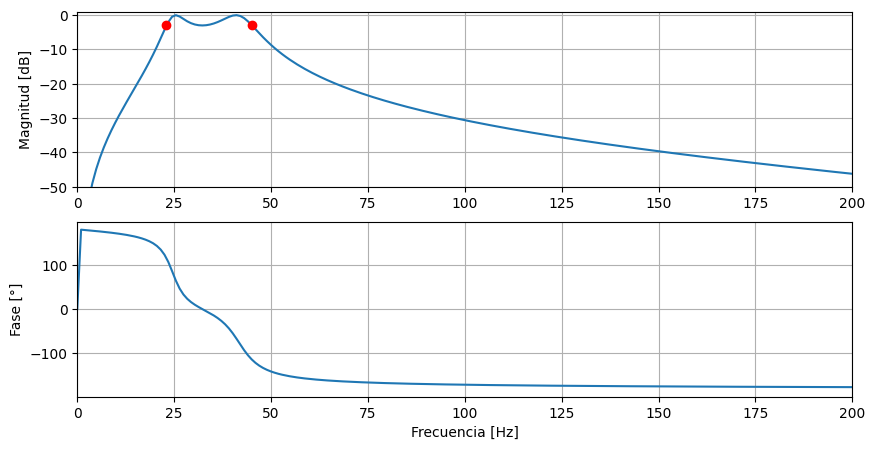

In [14]:
N = 2
Wn = 2*np.array([23.,45.])/sr
gpass = 3
b, a = sg.cheby1(N, gpass, Wn, btype='bandpass')

w1, W1, H1 = freqz_plot(b, a, sr)

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(w1, H1)
plt.ylabel('Magnitud [dB]')
plt.xlim(0, 200)
plt.ylim(-50, 1)
plt.plot(sr*Wn[0]/2, -3, 'ro')
plt.plot(sr*Wn[1]/2, -3, 'ro')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(w1, W1)
plt.ylabel('Fase [°]')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 200)
plt.grid(True)
plt.show()


### 5. Filtrado de la señal

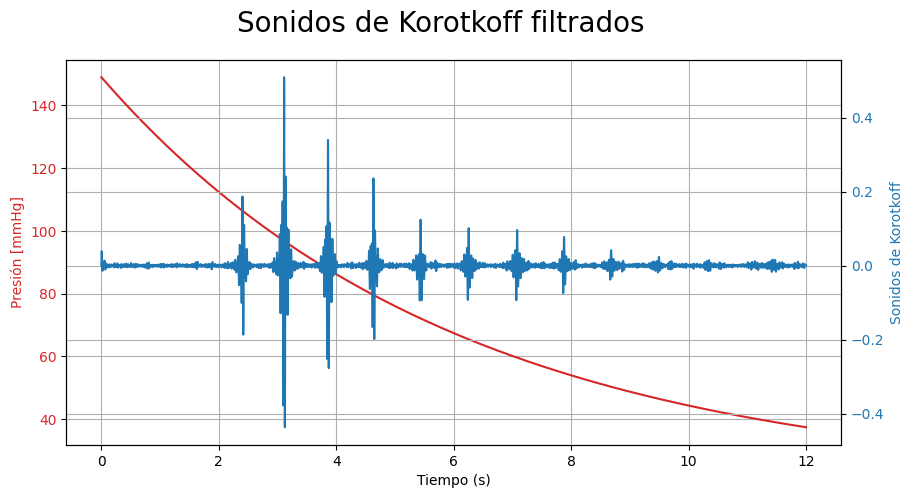

In [15]:
sonidos_filt = sg.filtfilt(b, a, sonidos)
plot_sounds_pressure(sonidos_filt, presion, t, title='Sonidos de Korotkoff filtrados')


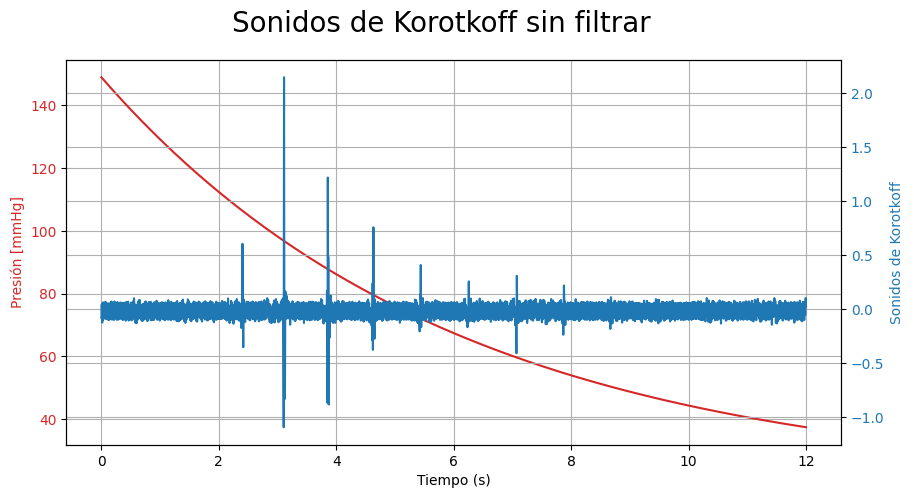

In [16]:
plot_sounds_pressure(sonidos, presion, t, title='Sonidos de Korotkoff sin filtrar')


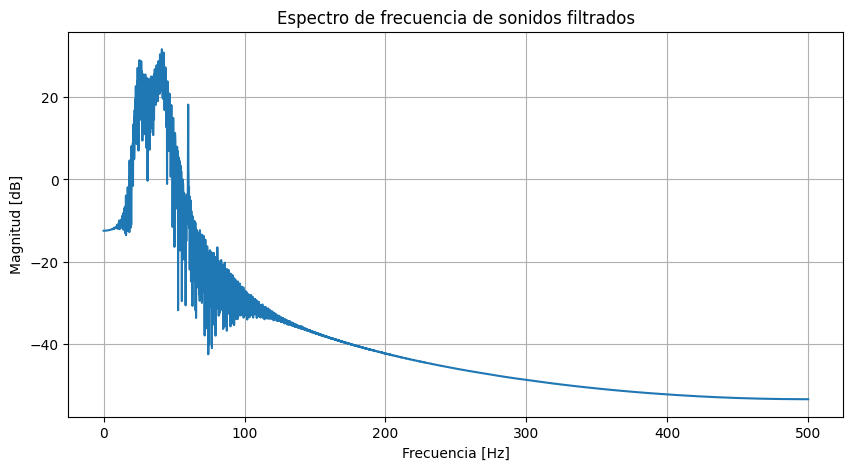

In [17]:
h, w = fou(sonidos_filt, sr)
plt.figure(figsize=(10, 5))
plt.plot(w, h)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de frecuencia de sonidos filtrados')
plt.grid()
plt.show()

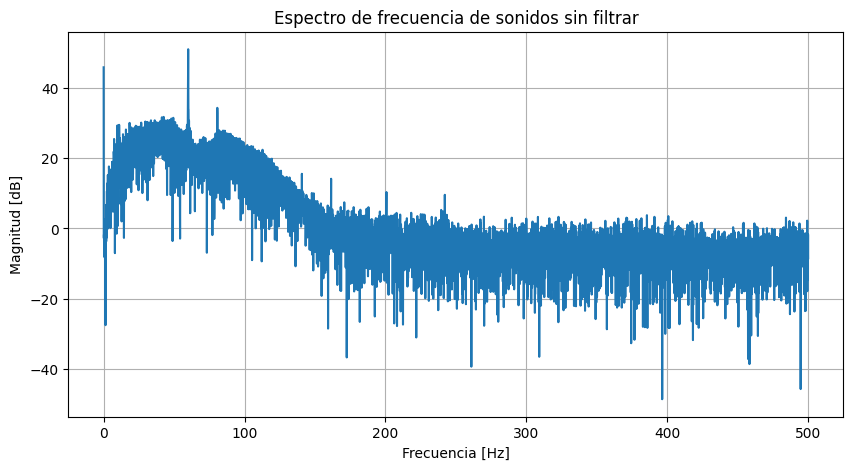

In [18]:
h, w = fou(sonidos, sr)
plt.figure(figsize=(10, 5))
plt.plot(w, h)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de frecuencia de sonidos sin filtrar')
plt.grid()
plt.show()

### 6. Obtención de presión arterial

Recordando: el método auscultatorio requiere del primer y el último sonido para hacer relación de la frecuencia asociada a dicho momento de tiempo.

Procedamos a obtener la envolvente de la señal y su valor absoluto mediante el uso de las funciones hilbert y abs, esto para facilitar la búsqueda de los puntos de interés.

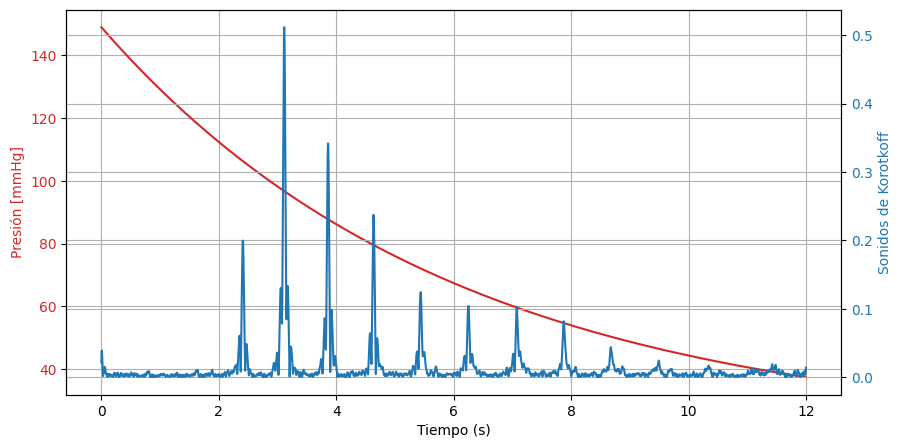

In [19]:
sonidos_abs = np.abs(hilbert(sonidos_filt))
plot_sounds_pressure(sonidos_abs, presion, t)


A simple vista se podría determinar que:
- El primer sonido ocurre poco depués de los 2 segundos
- El último sonido, el que sigue la secuencia decendiente, ocurre poco después de los 6 segundos

Necesitamos determinar la posición exacta de dichos picos, y para ello utilizaremos la función find_peaks de scipy, a la que tendremos que proporcionarle nuestra señal y un valor umbral que indique a partir de qué valor algo podría ser considerado como pico.

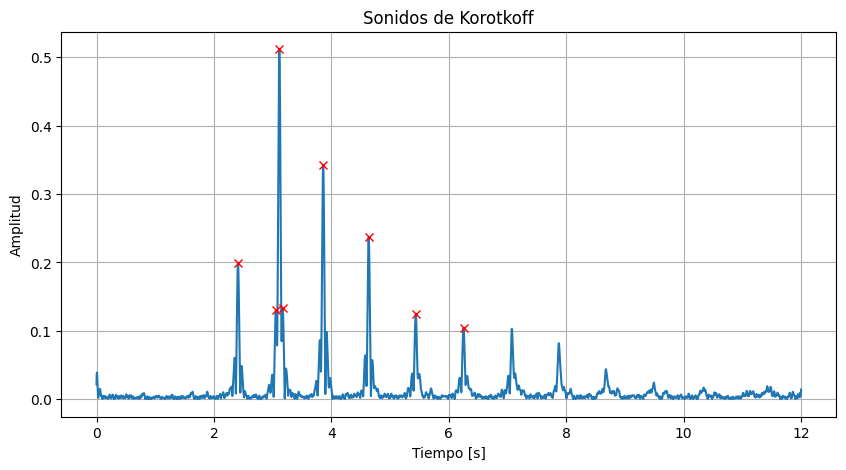

Picos en muestras, Picos en tiempo
[[2410.       2.41 ]
 [3055.       3.055]
 [3113.       3.113]
 [3171.       3.171]
 [3861.       3.861]
 [4635.       4.635]
 [5437.       5.437]
 [6251.       6.251]]


In [20]:
picos, altura = find_peaks(sonidos_abs, height=0.103)
picos_t = picos/sr

plt.figure(figsize=(10, 5))
plt.plot(t, sonidos_abs)
plt.plot(picos_t, sonidos_abs[picos], 'x', color='red')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Sonidos de Korotkoff')
plt.grid()
plt.show()

np.set_printoptions(suppress = True)
print("Picos en muestras, Picos en tiempo")
print(np.array([picos, picos_t]).T)


Regresemos a la señal de presión para obtener los valores asociados al primer y último pico

In [21]:
sis_n = picos[0]
sis = presion[sis_n]

dia_n = picos[-1]
dia = presion[dia_n]

print(f"Sistólica: {sis:.2f} mmHg\nDiastólica: {dia:.2f} mmHg")

Sistólica: 106.31 mmHg
Diastólica: 65.50 mmHg


Veamoslo de forma gráfica

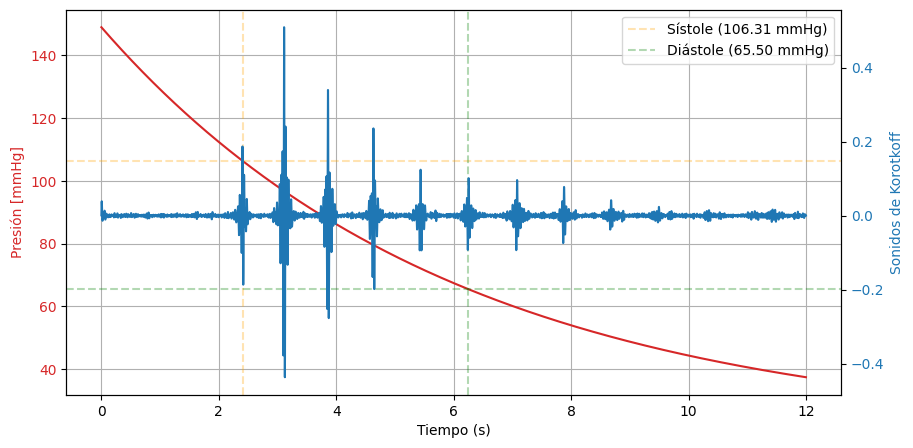

In [22]:
fig, ax1 = plt.subplots()

fig.set_size_inches(10, 5)

color = 'tab:red'
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Presión [mmHg]', color=color)
ax1.plot(t, presion, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

plt.axvline(x=picos_t[0], color='orange', linestyle='--', alpha=0.3, label=f'Sístole ({sis:.2f} mmHg)')
plt.axhline(y=sis, color='orange', linestyle='--', alpha=0.3)
plt.axvline(x=picos_t[-1], color='green', linestyle='--', alpha=0.3, label=f'Diástole ({dia:.2f} mmHg)')
plt.axhline(y=dia, color='green', linestyle='--', alpha=0.3)
plt.legend()

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sonidos de Korotkoff', color=color)
ax2.plot(t, sonidos_filt, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()